### **Import Packages and Libraries**

In [1]:
import os 
import time
import cv2
import copy
import  random
from datetime import datetime
from pathlib import Path
from typing import Tuple, Dict, Optional, Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import torchvision.models.segmentation as models

import torchmetrics 
from torchmetrics.classification import BinaryF1Score, BinaryJaccardIndex, BinaryRecall, BinaryAccuracy, BinaryPrecision

torch.set_float32_matmul_precision('high')

#set seed for reproducibility of results 
seed_value = 18

# Set seed for torch (for CPU)
torch.manual_seed(seed_value)
# Set seed for torch (for GPU)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if using multi-GPU
# Ensure that cuDNN works deterministically
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
os.chdir('../')
%pwd

'/home/akshar/Omdena/TB Detection/github/Omdena-PuneIndiaChapter-EarlyDetectionTuberculosis'

In [5]:
# setting up device 
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### **Create Custom Dataset for Segmentation** 

We define a custom PyTorch dataset class `LungSegmentationDataset` for loading and pre-processing lung segmentation data.

**Key features**:

- **Data loading:** It takes a DataFrame (`df`) containing image and mask paths and a base directory (`base_dir`) as input.
- **Resize:** It resizes images and masks to a specified size (`resize`).
- **Transformations:** It applies data augmentation transformations using `albumentations` library if provided.
- **`__len__` method:** Returns the total number of samples in the dataset.
- **`__getitem__` method:** Loads image and mask for a given index, resizes them, applies transformations, and returns the processed image and mask.

This class is essential for loading and preparing lung segmentation data for training and evaluation of a deep learning model.

In [35]:
class LungSegmentationDataset(Dataset):
    def __init__(self, df=None, base_dir=None, resize=None, transform=None):
        self.data = df
        self.base_dir = Path(base_dir)
        self.resize = resize
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_relative_path = self.data.iloc[idx, 0]
        mask_relative_path = self.data.iloc[idx, 1]

        img_path = self.base_dir / img_relative_path
        mask_path = self.base_dir / mask_relative_path

        # Load image and mask using OpenCV
        image = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        # Resize image and mask to input size
        image = cv2.resize(image, (self.resize, self.resize), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (self.resize, self.resize), interpolation=cv2.INTER_NEAREST)

        # # Convert image to RGB format (from BGR)
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        if self.transform:
            aug_pipeline = self.transform(image=image, mask=mask)
            image = aug_pipeline['image']
            mask = aug_pipeline['mask']

        return image, mask
   


### **Image Enhancement and Augmentation** 

#### **Enhance CXR Image using Grayscale Truncation**

Grayscale truncation is a technique used to normalize the intensity values of an image by removing extreme values. This function truncates the input image by clipping the intensity values to the range defined by the minimum and maximum values of the central region of the image.

 **Key Steps**:

- **Central region definition:** The central region of the image is defined as the area between the 25th and 75th percentiles of the image height and width.
- **Min and max calculation:** The minimum and maximum intensity values of the central region are calculated.
- **Truncation:** The input image is truncated by clipping the intensity values to the range defined by the calculated minimum and maximum values.

**Purpose**:

- Reduce the effect of extreme intensity values on the image
- Normalize the intensity values of the image
- Improve the contrast of the image

This pre-processing step is essential for preparing lung segmentation images for training and evaluation of deep learning models.

In [36]:
def grayscale_truncation(image, **kwrgs):

    height, width = image.shape 
    
    # define central region 
    central_region = image[height//4:3*height//4, width//4:3*width//4]

    # calculate min and max of central region 
    min_val, max_val = np.min(central_region) , np.max(central_region)

    # truncate the image  
    truncated_image = np.clip(image, min_val, max_val)

    return truncated_image


#### **Augmentation Pipeline**

Create two separate augmentation pipelines for training and validation data using the Albumentations library.

**Training Transform**:

1. **Grayscale Truncation:** Applies custom `grayscale_truncation` function to normalize image intensity.
2. **RGB Conversion:** Converts grayscale images to 3-channel RGB.
3. **Geometric Transformations:**
   - Horizontal Flip (50% probability)
   - Rotation (-10° to 10°, 50% probability)
   - Elastic Transform (30% probability)
4. **Intensity Transformations:**
   - Random Brightness and Contrast adjustment (40% probability)
   - Random Gamma adjustment (50% probability)
   - CLAHE (Contrast Limited Adaptive Histogram Equalization)
   - Gaussian Noise (30% probability)
5. **Normalization:** Applies mean and standard deviation normalization for RGB images.
6. **Tensor Conversion:** Converts the augmented image to a PyTorch tensor.

**Validation Transform**:

1. **Grayscale Truncation:** Same as training.
2. **RGB Conversion:** Same as training.
3. **CLAHE:** Applied to enhance image contrast.
4. **Normalization:** Same as training.
5. **Tensor Conversion:** Same as training.

The validation pipeline excludes aggressive augmentations to maintain data integrity for accurate model evaluation.

Both pipelines are configured to handle additional targets (masks) alongside the images.

In [37]:
# method to convert grayscale CXR image  to RGB suitable for model training
def convert_to_rgb(image, **kwargs):
    return np.stack([image] * 3, axis=-1)

In [38]:
def create_augmentation_pipeline():
    # Training transform with more aggressive augmentations
    train_transform = A.Compose([
        # Apply grayscale truncation to images only
        A.Lambda(image=grayscale_truncation, p=1.0),
        # Convert grayscale image to 3-channel RGB
        A.Lambda(image=convert_to_rgb, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=(-10,10), p=0.5),
        # Additional augmentations
        A.ElasticTransform(alpha=100, sigma=20, p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.4),
        A.RandomGamma(gamma_limit=(80,120), p=0.5),
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=1),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        # Normalize for RGB images (after grayscale to RGB conversion)
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ], additional_targets={'mask': 'mask'})

    # Validation transform with minimal augmentation
    validation_transform = A.Compose([
        # Apply grayscale truncation to images only
        A.Lambda(image=grayscale_truncation, p=1.0),
        # Convert grayscale image to 3-channel RGB
        A.Lambda(image=convert_to_rgb, p=1.0),
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=1),
        # No aggressive augmentations for validation, only resizing
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ], additional_targets={'mask': 'mask'})

    return train_transform, validation_transform

### **Split train, validation and test dataset**

In [39]:
cxr_df = pd.read_csv(SEG_DIR/'cxr_data.csv')[['images', 'masks']]
cxr_df.head()


,images,masks
0,images/0.png,masks/0-mask.png
1,images/1.png,masks/1-mask.png
2,images/2.png,masks/2-mask.png
3,images/3.png,masks/3-mask.png
4,images/5.png,masks/5-mask.png


In [40]:
train_df, test_df = train_test_split(cxr_df, test_size=0.1, random_state=18)

In [41]:
train_df, val_df = train_test_split(train_df, test_size=0.20, random_state=18)

In [42]:
train_df.shape[0], val_df.shape[0], test_df.shape[0]

(506, 127, 71)

### **Create Dataloaders for Model Training**

DataLoaders are used to load and iterate over the dataset in batches, allowing for efficient training and evaluation of the model.

**Key Steps**:

1. **Batch Size:** Define the batch size for each DataLoader, which determines the number of samples loaded and processed together.
2. **Dataset:** Pass the corresponding dataset (training, validation, or testing) to the DataLoader.
3. **DataLoader Creation:** Create a DataLoader instance for each dataset, specifying the batch size, shuffle option, and number of worker threads.

**DataLoaders**:

* **Training DataLoader:** Loads the training dataset in batches, shuffling the data to ensure randomness and prevent overfitting.
* **Validation DataLoader:** Loads the validation dataset in batches, without shuffling to maintain the original data order.
* **Testing DataLoader:** Loads the testing dataset in batches, without shuffling to maintain the original data order.


By creating DataLoaders, we can efficiently manage the data loading process and focus on training and evaluating the model.

In [43]:
def get_dataloaders(config: Dict, 
                     train_data:pd.DataFrame,
                     valid_data:pd.DataFrame,
                     test_data:pd.DataFrame)->Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Creates and returns data loaders for the training, validation, and test datasets.

    Parameters:
    config (dict): A dictionary containing configuration parameters, including the data directory, batch size, and resize dimensions.

    Returns:
    tuple: A tuple containing three DataLoader objects for the training, validation, and test datasets, respectively.

    """
    # Create datasets with transformations
    train_transform, val_transform = create_augmentation_pipeline()
    datasets = {
        'train': LungSegmentationDataset(df=train_data, base_dir=SEG_DIR, resize=config['resize'], transform=train_transform),
        'validation': LungSegmentationDataset(df=valid_data, base_dir=SEG_DIR, resize=config['resize'], transform=val_transform),
        'test': LungSegmentationDataset(df=test_data, base_dir=SEG_DIR, resize=config['resize'], transform=val_transform)
    }

    # Create dataloaders without sampling or class weights
    dataloaders = {
        'train': DataLoader(datasets['train'], batch_size=config['batch_size'], shuffle=True, num_workers=4),
        'validation': DataLoader(datasets['validation'], batch_size=config['batch_size'], shuffle=False, num_workers=4),
        'test': DataLoader(datasets['test'], batch_size=config['batch_size'], shuffle=False, num_workers=4)
    }

    return dataloaders['train'], dataloaders['validation'], dataloaders['test']

_________________

### **Model Training**

#### **Model Initialization**

Initializes and prepares a DeepLabV3 model for lung segmentation tasks.

**Key Steps**:

1. **Model Selection:**
   - Chooses between DeepLabV3 with ResNet50 or MobileNetV3 backbone based on the configuration.
   - Loads pre-trained weights for the selected model.

2. **Backbone Freezing:**
   - Freezes all layers in the backbone to preserve pre-trained features.

3. **Classifier Modification:**
   - Replaces the final classifier layer to adjust for the lung segmentation task.
   - Sets the output channels to 2 (typically for binary segmentation).

4. **Device Allocation:**
   - Moves the model to the specified device (CPU or GPU).

5. **Model Compilation:**
   - Compiles the model using PyTorch's `compile` function with the 'eager' backend for potential performance improvements.

**Purpose**:

This prepares a state-of-the-art segmentation model for lung segmentation by:
- Utilizing transfer learning from pre-trained weights.
- Adapting the model for the specific task of lung segmentation.
- Optimizing the model for the available hardware.

The resulting model is ready for fine-tuning on lung segmentation data.

In [16]:
def initialize_model(config : Dict,
                     device : torch.device):
    """
    Prepare the DeepLabV3_ResNet50 model for lung segmentation.

    Args:
        device (torch.device): The device to move the model to (e.g., 'cuda' or 'cpu').

    Returns:
        torch.nn.Module: The prepared model.
    """
    model_name = config.get('model_name', 'deeplabv3_resnet50')
    if model_name == 'deeplabv3_resnet50' : 
        # Load the model with pre-trained weights
        model = models.deeplabv3_resnet50(weights=models.DeepLabV3_ResNet50_Weights.DEFAULT, progress=True)
    else:
        model = models.deeplabv3_mobilenet_v3_large(weights='DEFAULT', progress=True)
    # Freeze all layers in the backbone
    for param in model.backbone.parameters():
        param.requires_grad = False

    # Fine-tune the segmentation layer
    model.classifier[4] = nn.Conv2d(
        in_channels=256,
        out_channels=2,  # Adjust based on segmentation task
        kernel_size=(1, 1)
    )
   
        
    # Move the model to the specified device
    model = model.to(device)

    # Compile the model 
    model = torch.compile(model,backend='eager')

    return model



#### **Loss Functions**

##### **1. Dice Loss**

The **Dice Loss** is a popular loss function for image segmentation tasks, especially in medical imaging, as it measures the overlap between predicted segmentation masks and ground truth masks. It is based on the **Dice coefficient**, which ranges from 0 (no overlap) to 1 (perfect overlap). The loss function is defined as:

$$
\text{Dice Coefficient} = \frac{2 \times |P \cap G| + \epsilon}{|P| + |G| + \epsilon}
$$
Where:
- $P$ represents the predicted segmentation,
- $G$ represents the ground truth segmentation,
- $\epsilon$ is a small constant (smoothing factor) added to avoid division by zero.

The Dice Loss is calculated as  $ (1 - \text{Dice Coefficient})$ , and it helps to optimize the model for better overlap between the predicted and true segmentation masks. It is particularly effective in scenarios where the target region (e.g., lung in medical images) is small compared to the background.

In [18]:
class DiceLoss(nn.Module):
    """
    A custom PyTorch module for calculating the Dice Loss for image segmentation tasks.
    The Dice Loss measures the overlap between predicted segmentation masks and ground truth masks.
    """
    def __init__(self, smooth=1e-6):
        """
        Initializes the DiceLoss module with the specified smoothing factor.

        Args:
            smooth (float, optional): A small constant added to avoid division by zero. Defaults to 1e-6.
        """
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, logits, targets):
        """
        Computes the Dice Loss between predicted segmentation masks (logits) and ground truth masks (targets).

        Args:
            logits (torch.Tensor): The predicted segmentation masks, output from the model.
            targets (torch.Tensor): The ground truth segmentation masks.

        Returns:
            torch.Tensor: The Dice Loss value. A lower value indicates better overlap between predicted and ground truth masks.
        """
        # For binary segmentation, take the second channel (index 1)
        if logits.shape[1] == 2:
            logits = logits[:, 1, :, :]
        
        # Ensure inputs are the same shape after adjustment
        if logits.shape != targets.shape:
            raise ValueError(f"Logits shape {logits.shape} does not match targets shape {targets.shape}")
        # apply sigmoid to the logits to get the probabilities.
        probs = torch.sigmoid(logits)
        # flatten the tensors to compute Dice score
        probs = probs.view(-1)
        targets = targets.view(-1)
        # compute the intersection between prediction and ground truth(actual mask)
        intersection = (probs * targets).sum()
        # calculate dice co-efficient 
        dice_coeff = (2.*intersection+self.smooth) / (probs.sum() + targets.sum() + self.smooth)

        return 1- dice_coeff

##### **2. Combo Loss:**

ComboLoss is a hybrid loss function that leverages the strengths of both Dice Loss and BCE Loss. Dice Loss is effective in capturing the similarity between predicted and ground truth masks, while BCE Loss helps to penalize false positives and false negatives.

**Key Components**

1. **Dice Loss:**
   - Measures the overlap between predicted and ground truth masks.
   - Uses the Sigmoid function to convert logits to probabilities.
   - Smooths the loss using a small value to avoid division by zero.

2. **BCE Loss:**
   - Computes the binary cross-entropy loss between predicted logits and ground truth masks.
   - Uses a weighted BCE loss to emphasize the importance of positive class predictions.

3. **Combo Loss:**
   - Combines the Dice Loss and BCE Loss components using a weighted sum.
   - The weight for Dice Loss is controlled by the `alpha` parameter, while the weight for BCE Loss is `1 - alpha`.

**Parameters**

* `alpha` (float, optional): Weight for Dice Loss component. Defaults to 0.5.
* `smooth` (float, optional): Smoothing factor for Dice Loss. Defaults to 1e-6.
* `bce_weight` (float, optional): Weight for positive class in BCE Loss. Defaults to 1.0.

**Usage**

To use the ComboLoss module, simply create an instance of the class and pass it to your PyTorch model as the loss function. The `forward` method will compute the Combo Loss value given the predicted logits and ground truth masks.


In [19]:
class ComboLoss(nn.Module):
    """
    A custom module for calculating the Combo Loss (Dice Loss + BCE Loss) for image segmentation tasks.
    This loss function combines the benefits of Dice Loss and Binary Cross-Entropy Loss.
    """
    def __init__(self, alpha=0.5, smooth=1e-6, bce_weight=1.0):
        """
        Initializes the ComboLoss module.

        Args:
            alpha (float, optional): Weight for Dice Loss component. BCE weight will be (1 - alpha). Defaults to 0.5.
            smooth (float, optional): Smoothing factor for Dice Loss. Defaults to 1e-6.
            bce_weight (float, optional): Weight for positive class in BCE Loss. Defaults to 1.0.
        """
        super(ComboLoss, self).__init__()
        self.alpha = alpha
        self.smooth = smooth
        self.bce_weight = bce_weight

    def forward(self, logits, targets):
        """
        Computes the Combo Loss between predicted segmentation masks (logits) and ground truth masks (targets).

        Args:
            logits (torch.Tensor): The predicted segmentation masks, output from the model.
            targets (torch.Tensor): The ground truth segmentation masks.

        Returns:
            torch.Tensor: The Combo Loss value.
        """
        # For binary segmentation, take the second channel (index 1)
        if logits.shape[1] == 2:
            logits = logits[:, 1, :, :]
        
        # Ensure inputs are the same shape after adjustment
        if logits.shape != targets.shape:
            raise ValueError(f"Logits shape {logits.shape} does not match targets shape {targets.shape}")

        # Dice Loss component
        probs = torch.sigmoid(logits)
        probs_flat = probs.view(-1)
        targets_flat = targets.view(-1)
        intersection = (probs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (probs_flat.sum() + targets_flat.sum() + self.smooth)

        # BCE Loss component
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets.float(), reduction='mean', 
                                                      pos_weight=torch.tensor([self.bce_weight], device=logits.device))

        # Combine losses
        combo_loss = self.alpha * dice_loss + (1 - self.alpha) * bce_loss

        return combo_loss

### **Early Stopping**

The `EarlyStopping` class implements an early stopping mechanism for model training, helping to prevent overfitting and optimize training time.

**Key Features**:

1. **Flexible Metric Tracking:** 
   - Can monitor various metrics like validation loss or accuracy.
   - Supports both minimization (e.g., for loss) and maximization (e.g., for accuracy) objectives.

2. **Customizable Patience:** 
   - Allows setting a patience period to wait for improvement before stopping.

3. **Minimum Improvement Threshold:** 
   - Defines a minimum delta for considering an improvement significant.

4. **Best Model Preservation:** 
   - Option to restore the best model weights after stopping.

5. **Dynamic Status Updates:** 
   - Provides status messages about improvement or lack thereof during training.

In [20]:
class EarlyStopping:
    """
    Class to implement early stopping during model training based on a specified metric.

    Args:
        patience (int): Number of epochs to wait for improvement before stopping.
        min_delta (float): Minimum required improvement.
        restore_best_weights (bool): Whether to restore the best model weights after stopping.
        tracking_metric (str): Metric to track for early stopping, e.g., "val_loss" or "accuracy".
        mode (str): Whether to "minimize" or "maximize" the tracked metric. Use "min" for loss, "max" for accuracy or other metrics.
    """

    def __init__(self, patience: int = 5, min_delta: float = 0.0, restore_best_weights: bool = False, tracking_metric: str = "val_loss", mode: str = "min"):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.tracking_metric = tracking_metric
        self.mode = mode
        
        # Depending on mode, set the initial best_metric to either a large or small value
        if mode == "min":
            self.best_metric = float('inf')  # For minimizing (e.g., loss)
        elif mode == "max":
            self.best_metric = float('-inf')  # For maximizing (e.g., accuracy)
        else:
            raise ValueError("mode should be 'min' for minimizing or 'max' for maximizing.")
        
        self.best_model = None
        self.counter = 0
        self.status = ""

    def __call__(self, model: torch.nn.Module, current_metric: float) -> bool:
        """
        Call the EarlyStopping object during model training.

        Args:
            model (torch.nn.Module): The model being trained.
            current_metric (float): The current value of the metric being tracked.

        Returns:
            bool: True if early stopping should be triggered, False otherwise.
        """
        # Check if current_metric is valid
        if not isinstance(current_metric, (int, float)):
            raise ValueError("current_metric must be a number")
        
        # Determine if improvement has been made based on the mode (minimize or maximize)
        if self.mode == "min" and current_metric < self.best_metric - self.min_delta:
            # Improvement for minimizing
            self.best_metric = current_metric
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        elif self.mode == "max" and current_metric > self.best_metric + self.min_delta:
            # Improvement for maximizing
            self.best_metric = current_metric
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            # No improvement
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True

        return False

### **Training Components (Optimizer, Criterion, EarlyStopping)**

The `get_components` function initializes various components required for training a deep learning model, including the optimizer, loss function, early stopping mechanism, and learning rate scheduler.

**Parameters**:

- `config` (Dict): Configuration dictionary containing settings for the model and training process.
- `model` (nn.Module): The neural network model to be trained.


**Initialization Steps**:

1. **Optimizer:**
   - Initializes an Adam optimizer with parameters extracted from the configuration.
   - Learning rate (`lr`) and weight decay (`weight_decay`) (L2 Regularization) are set using default values if not specified in the configuration.

2. **Loss Function:**
   - Selects the loss function based on the configuration.
   - If `loss_fn` is set to `'dice'`, initializes a `DiceLoss` object.
   - Otherwise, initializes a `ComboLoss` object with parameters for alpha and BCE weight from the configuration.

3. **Learning Rate Scheduler:**
   - Initializes a `ReduceLROnPlateau` scheduler to adjust the learning rate during training.
   - Parameters for the scheduler (mode, factor, patience, verbose, threshold, threshold mode, min_lr, cooldown) are set using values from the configuration.

4. **Early Stopping:**
   - Initializes an `EarlyStopping` object to monitor a specified metric and stop training early if no improvement is observed.
   - Parameters for early stopping (patience, min_delta, tracking_metric, mode, restore_best_weights) are set using values from the configuration.

In [21]:
def get_components(config:Dict, model:nn.Module)->Tuple[optim.Optimizer, nn.Module, EarlyStopping, ReduceLROnPlateau]:
    # initialize optimizer 
    optimizer = optim.Adam(params=model.parameters(), 
                           lr=config.get('lr',1e-4) , 
                           weight_decay=config.get('weight_decay',1e-4))
    # Initialize loss function
    loss = config.get('loss_fn','dice')
    if loss =='dice':
        loss_fn = DiceLoss()
    else:
        loss_fn = ComboLoss(alpha=config.get('alpha', 0.5), 
                            bce_weight=config.get('bce_weight', 1))
    # Learning Rate Scheduler
    lr_scheduler= ReduceLROnPlateau(
                        optimizer= optimizer,
                        mode='max',           
                        factor=config.get('lr_factor', 0.5),           
                        patience=config.get('lr_patience', 5),           
                        verbose=True,         
                        threshold=config.get('lr_threshold', 0.001),      
                        threshold_mode='abs', 
                        min_lr=config.get('min_lr',1e-6),
                        cooldown = config.get('lr_cooldown', 5)
                       )
    
    # Initialize EarlyStopping with configuration
    early_stopping = EarlyStopping(
        patience=config.get('es_patience', 5),
        min_delta=config.get('es_delta', 0.001),
        tracking_metric=config.get('es_metric', 'val_loss'),
        mode=config.get('es_mode', 'min'),
        restore_best_weights=True
    )
    return optimizer, loss_fn, early_stopping, lr_scheduler

#### **Training and Validation Loops**

The training and validation loops are the core components of the model training process. They define how the model is updated and evaluated during training.

**Training Loop (train_step) :**

The `train_step` function implements the training loop, which is responsible for updating the model parameters based on the training data.

**Key Steps**:

1. **Set model to training mode:** Sets the model to training mode using `model.train()`.
2. **Iterate through batches:** Processes images and masks from the dataloader.
3. **Zero gradient:** Resets the gradient of the optimizer using `optimizer.zero_grad()`.
4. **Forward pass:** Passes the input images through the model to get the output predictions.
5. **Calculate loss:** Computes the loss between the predicted outputs and the ground truth masks using the specified loss function.
6. **Backward pass:** Computes the gradient of the loss with respect to the model parameters using `loss.backward()`.
7. **Optimization:** Updates the model parameters using `optimizer.step()`.
8. **Metric calculation:** Computes various metrics for model performance evaluation.


**Validation Loop (validation_step) :**

The `validation_step` function implements the validation loop, which evaluates the model's performance on the validation dataset without updating the model parameters.

**Key Steps**:

1. **Set model to evaluation mode:** Sets the model to evaluation mode using `model.eval()`.
2. **Disable gradient computation:** Uses `torch.inference_mode()` to disable gradient computation.
3. **Iterate through batches:** Processes images and masks from the validation dataloader.
4. **Forward pass:** Passes the input images through the model to get the output predictions.
5. **Calculate loss:** Computes the loss between the predicted outputs and the ground truth masks.
6. **Metric calculation:** Computes various metrics for model performance evaluation.

**Returns(train_step and validation_step)**:
- Epoch loss (average loss over all batches)
- Dictionary of computed metrics

**Key Features**:

- **Device Agnostic:** Both functions support running on CPU or GPU by using the specified device.
- **Flexible Metrics:** Supports multiple metrics through a dictionary of metric objects.
- **Binary Segmentation Support:** Handles binary segmentation tasks by focusing on the appropriate output channel.
- **Efficient Computation:** Uses PyTorch's built-in functions for efficient computation and memory usage.

These loops form the foundation of the training process, allowing for iterative improvement of the model on the training data while monitoring its performance on the validation set.

In [44]:
#evaluation metrics 
metrics = {
    "accuracy": BinaryAccuracy().to(device),
    "recall": BinaryRecall().to(device),
    'precision': BinaryPrecision().to(device),
    "f1_score" : BinaryF1Score().to(device), 
    "dice": torchmetrics.Dice().to(device),
    "jaccard_index": BinaryJaccardIndex().to(device),
    
}

In [23]:
def train_step(dataloader:DataLoader,
               model: nn.Module,
               optimizer:optim.Optimizer,
               loss_fn:nn.Module,
               device:torch.device,
               metrics:Dict)->Tuple[float,Dict]: 
    model.train()
    running_loss = 0.0

    for images, masks in dataloader:

        images, masks  =images.to(device), masks.to(device).float()
        # Normalize masks to 0 and 1
        masks = (masks > 0).int()
        # zero gradient
        optimizer.zero_grad()

        #forward pass
        outputs = model(images)['out']
        #calculate loss
        loss = loss_fn (outputs, masks)
        
        #backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # accumulate loss 
        running_loss += loss.item() * images.size(0)    
        
        # For binary segmentation, take the second channel (index 1) for predictions
        if outputs.shape[1] == 2:
            preds = (torch.sigmoid(outputs[:, 1, :, :]) > 0.5).float()
        else:
            preds = (torch.sigmoid(outputs) > 0.5).float()
        
        # Update the metrics with predictions and ground truth
        for name, metric in metrics.items():
            metric.to(device)
            metric.update(preds, masks)
              
    #calculate loss epoch 
    epoch_loss = running_loss / len(dataloader.dataset)
    # Compute metrics 
    train_metrics = {name: metric.compute().item() for name, metric in metrics.items()}
    # Reset all metrics after computing
    for metric in metrics.values():
        metric.reset()

    return epoch_loss, train_metrics    

In [24]:
def validation_step(dataloader:DataLoader,
               model: nn.Module,
               loss_fn:nn.Module,
               device:torch.device,
               metrics:Dict)->Tuple[float,Dict]:
    
    # set the model to eval mode 
    model.eval()
    #initialize placeholder to accumulate loss
    running_loss = 0.0
    
    with torch.inference_mode():
        for images, masks in dataloader:
            # move images and masks to device 
            images, masks = images.to(device), masks.to(device).float()
            # Normalize masks to 0 and 1
            masks = (masks > 0).int()
            
            #forward pass 
            outputs = model(images)['out']
            
            # compute loss and accumulate loss after each batch
            loss = loss_fn(outputs, masks)
            running_loss += loss.item() * images.size(0)
            
            # For binary segmentation, take the second channel (index 1) for predictions
            if outputs.shape[1] == 2:
                preds = (torch.sigmoid(outputs[:, 1, :, :]) > 0.5).float()
            else:
                preds = (torch.sigmoid(outputs) > 0.5).float()

            # Update the metrics with predictions and ground truth
            for name, metric in metrics.items():
                metric.to(device)
                metric.update(preds, masks)
            
    #calculate loss epoch 
    epoch_loss = running_loss / len(dataloader.dataset)
    # Compute metrics 
    val_metrics = {name: metric.compute().item() for name, metric in metrics.items()}
    # Reset all metrics after computing
    for metric in metrics.values():
        metric.reset()

    return epoch_loss, val_metrics



### **Model training Pipeline** 

The `train_model` function is responsible for the end-to-end training of a model, including the training and validation loops, early stopping, and learning rate scheduling.

**Parameters**:

- `config` (Dict): A dictionary containing the configuration settings for training, such as the number of epochs, learning rate, and early stopping parameters.
- `model` (nn.Module): The neural network model to be trained.
- `train_loader` (DataLoader): The dataloader for the training dataset.
- `val_loader` (DataLoader): The dataloader for the validation dataset.
- `loss_fn` (nn.Module): The loss function to be used during training.
- `optimizer` (optim.Optimizer): The optimizer to be used for updating the model parameters.
- `early_stopping` (Optional[EarlyStopping]): An optional early stopping object to prevent overfitting.
- `lr_scheduler` (Optional[ReduceLROnPlateau]): An optional learning rate scheduler to adjust the learning rate during training.
- `device` (torch.device): The device (CPU or GPU) to be used for training.
- `metrics` (dict): A dictionary of metric objects to track during training and validation.

**Key Steps**:

1. **Initialization:**
   - Moves the loss function to the specified device.
   - Initializes dictionaries to store training and validation loss, as well as metric values.
   - Determines the best model based on the specified metric.

2. **Training Loop:**
   - Iterates over the specified number of epochs.
   - Runs the training step and logs the training loss and metrics.
   - Runs the validation step and logs the validation loss and metrics.
   - Updates the learning rate scheduler (if provided).
   - Checks for early stopping (if provided) and breaks the loop if triggered.
   - Saves the best model weights based on the specified metric.

3. **Best Model Loading:**
   - Loads the best model weights if they were saved during training.
   - Saves the best model to a file with the specified naming convention.

**Returns**:

A tuple containing the training history dictionary and the trained model.

The `train_model` function provides a comprehensive training pipeline, allowing to train a model, monitor its performance, and save the best model for further use or deployment.

In [25]:
def train_model(config: Dict,
                model: nn.Module, 
                train_loader: DataLoader, 
                val_loader: DataLoader, 
                loss_fn: nn.Module, 
                optimizer: optim.Optimizer, 
                early_stopping: Optional[EarlyStopping],
                lr_scheduler : Optional[ReduceLROnPlateau],
                device: torch.device,
                metrics: dict)-> Tuple[Dict[str, Any], nn.Module]:
    loss_fn = loss_fn.to(device)
    # Initialize lists to store training and validation loss and metrics
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_metrics": {name: [] for name in metrics},
        "val_metrics": {name: [] for name in metrics}
    }
    best_metric_value = float('-inf')  # or float('inf') if minimizing
    best_model_state = None
    # Loop over the epochs
    for epoch in range(config['epochs']):
        
        start_time = time.time()
        print('=='* 15)
        print(f"Epoch {epoch+1}/{config['epochs']}")

        # Training step
        train_loss, train_metrics = train_step(train_loader, model, optimizer, loss_fn, device, metrics)
        print(f"Train Loss: {train_loss:.4f}")
        # For training metrics
        print(" | ".join([f"Train {name}: {value:.4f}" for name, value in train_metrics.items()]))
        # Validation step
        val_loss, val_metrics = validation_step(val_loader, model, loss_fn, device, metrics)
        print(f"Val Loss: {val_loss:.4f}")
        # For validation metrics
        print(" | ".join([f"Val {name}: {value:.4f}" for name, value in val_metrics.items()]))

        # Store the results for this epoch
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        for name, value in train_metrics.items():
            history["train_metrics"][name].append(value)
        for name, value in val_metrics.items():
            history["val_metrics"][name].append(value)
        
        # Step the scheduler
        if lr_scheduler:
            lr_scheduler.step(val_metrics[config['es_metric']])
            # Log the current learning rate
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1}, Current LR: {current_lr}")
        
        # Time per epoch
        epoch_time = time.time() - start_time
        print(f"Time per epoch: {epoch_time:.2f} seconds\n")

        # Early stopping check
        if early_stopping:
            tracking_metric = val_loss if early_stopping.tracking_metric == 'val_loss' else val_metrics.get(early_stopping.tracking_metric)
            if early_stopping(model, tracking_metric):
                print(f"Early stopping triggered. Best {early_stopping.tracking_metric}: {early_stopping.best_metric:.4f}")
                print(f"Restoring best model weights from epoch {epoch + 1 - early_stopping.counter}")
                break
            print(early_stopping.status)
        # Save best model
        if val_metrics[config['es_metric']] > best_metric_value:  # Change to < if minimizing
            best_metric_value = val_metrics[config['es_metric']]
            best_model_state = model.state_dict().copy()

         
    # Load best model weights
    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with {config['es_metric']}: {best_metric_value:.4f}")
        # Save the entire model with best metric value
        model_name = f"{config['model_name']}_{config['es_metric']}_{best_metric_value:.4f}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
        torch.save(model, model_name)
        print(f"Saved best model as {model_name}")
    print('=='* 15)
    return history, model

### **Lung Segmentation Model Training**

In [45]:
# configuration for model training
config = dict(
    model_name = 'deeplabv3_mobilenet', # options 'deeplabv3_mobilenet' and 'deeplabv3_resnet50'
    epochs = 50,
    resize = 520, #required for DeepLabV3_ResNet50
    batch_size= 16,
    #optimizer parameters 
    lr = 0.0005,
    weight_decay = 1e-4, #L2 Regularization
    #loss function configurations 
    loss_fn = 'dice',
    alpha = 1,
    bce_weight = 1.5,
    # learning rate scheduler configs
    lr_patience = 5,
    lr_factor = 0.5,
    lr_threshold = 0.001, 
    min_lr = 1e-6,
    lr_cooldown = 3,
    # early stopping configurations
    es_patience = 10,
    es_delta = 0.001,
    es_metric = 'dice' , #select'val_loss' or one of evalution metric ['accuracy', 'dice', 'jaccard', 'recall', 'f1']
    es_mode = 'max'       # min if 'val_recall' else 'max'
)

________________________

### **Evaluate on Test Dataset**

#### **Prepare Model for Segmentation**

In [50]:
def load_model(state_dict_path : Path,
               device : torch.device):
    """
    Prepare the DeepLabV3_MobileNetV3_Large model for lung segmentation.
    
    Args:
        state_dict_path (Path): The path to the state dictionary file.
        device (torch.device): The device to move the model to (e.g., 'cuda' or 'cpu').
        
    Returns:
        torch.nn.Module: The prepared model.
        
    Raises:
        FileNotFoundError: If the state dictionary file does not exist.
        RuntimeError: If there is an issue loading the state dictionary.
    """
    # Check if the state dictionary path exists
    if not state_dict_path.is_file():
        raise FileNotFoundError(f"State dictionary file not found: {state_dict_path}")
    # initialize the model withoutt pre-trained weights
    model = models.deeplabv3_mobilenet_v3_large(weights=None)
    # Freeze all layers in the backbone
    for param in model.backbone.parameters():
        param.requires_grad = False
    # Fine-tune the segmentation layer
    model.classifier[4] = nn.Conv2d(
        in_channels=256,
        out_channels=2,  # Adjust based on segmentation task
        kernel_size=(1, 1)
    )
    try:
        state_dict = torch.load(state_dict_path, map_location=device)
        # Remove the '_orig_mod.' prefix from the keys in the state_dict
        state_dict = {k.replace('_orig_mod.', ''): v for k, v in state_dict.items()}
        state_dict = {k:v for k, v in state_dict.items() if not k.startswith("aux_classifier.")}
        model.load_state_dict(state_dict)
    except RuntimeError as e:
        raise RuntimeError(f"Error loading state dictionary: {e}")   
    # Move the model to the specified device
    model = model.to(device)

    # Compile the model 
    model = torch.compile(model)

    return model


In [5]:
# path to the trained model state dictionary 
from src.constants import SEG_MODEL_PATH

In [51]:
model = load_model(state_dict_path=SEG_MODEL_PATH, device=device)


In [46]:
# create test dataloader for evaluation  
_, _, test_loader = get_dataloaders(config, train_df, val_df, test_df)

In [47]:
# declare evaluation metrics to compute
metrics = {
    "accuracy": BinaryAccuracy().to(device),
    "recall": BinaryRecall().to(device),
    'precision': BinaryPrecision().to(device),
    "f1_score" : BinaryF1Score().to(device), 
    "dice": torchmetrics.Dice().to(device),
    "jaccard_index": BinaryJaccardIndex().to(device),
    
}

In [48]:
def evaluation_step(test_loader: DataLoader,
                    model: nn.Module,
                    device: torch.device,
                    metrics: Dict) -> Dict:
    """
    Performs a single evaluation step on a test dataset using a given model and metrics.

    Args:
    test_loader (torch.utils.data.DataLoader): The DataLoader for the test dataset.
    model (torch.nn.Module): The model to be evaluated.
    device (torch.device): The device (CPU/GPU) to perform computations on.
    metrics (Dict): A dictionary containing the evaluation metrics to be used.

    Returns:
    Dict: A dictionary containing the computed evaluation metrics.
    """
    
    # Set the model to evaluation mode
    model.eval()
    
    # Turn off gradient calculation for inference
    with torch.inference_mode():
        for images, masks in test_loader:
            # Move images and masks to the specified device (GPU/CPU)
            images, masks = images.to(device), masks.to(device).float()
            # Normalize masks to 0 and 1 for binary segmentation
            masks = (masks > 0).int()
            # Forward pass through the model
            outputs = model(images)['out']
            # For binary segmentation, take the second channel (index 1) for predictions
            if outputs.shape[1] == 2:
                preds = (torch.sigmoid(outputs[:, 1, :, :]) > 0.5).float()
            else:
                preds = (torch.sigmoid(outputs) > 0.5).float()

            # Update the metrics with the predictions and true labels
            for name, metric in metrics.items():
                metric.to(device)
                metric.update(preds, masks)
    
   
    # Compute evaluation metrics
    test_metrics = {name: metric.compute().item() for name, metric in metrics.items()}
    
    # Reset all metrics for future evaluations
    for metric in metrics.values():
        metric.reset()

    return test_metrics

In [53]:
# compute evaluation metric on testing data
eval_metric  = evaluation_step(test_loader=test_loader, model=model, device=device, metrics=metrics)

In [55]:
# display evaluation metrics. 
print("Evaluation Metrics on Test Dataset :")
for metric, value in eval_metric.items():
    print(f"{metric.upper()} : {value:.4f}")

Evaluation Metrics on Test Dataset :
ACCURACY : 0.9787
RECALL : 0.9519
PRECISION : 0.9612
F1_SCORE : 0.9565
DICE : 0.9565
JACCARD_INDEX : 0.9167


#### **Display Segmented Lungs**

In [56]:
def inverse_normalize(tensor, mean=[0.485, 0.456, 0.406] , std=[0.229, 0.224, 0.225]):
    """
    Reverses the normalization of a tensor.
    
    Args:
        tensor (torch.Tensor): The normalized image tensor.
        mean (list): Mean values used for normalization.
        std (list): Standard deviation values used for normalization.
        
    Returns:
        torch.Tensor: The tensor with normalization reversed.
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # reverse normalization
    return tensor

In [32]:
def create_segmented_lung(image, mask):
    """Creates a segmented lung image with black background."""
    segmented = image.copy()
    segmented[mask == 0] = 0
    return segmented

In [33]:
def display_random_predictions(model, test_dataset, device, num_samples=5):
    """
    Displays the image, true mask, truncated predicted mask, and segmented lung for random images from the test dataset.
    
    Args:
        model (nn.Module): The trained segmentation model.
        test_dataset (LungSegmentationDataset): The test dataset.
        device (torch.device): The device to use for inference.
        num_samples (int): The number of random samples to display (default is 5).
    """
    model.eval()
    with torch.no_grad():
        # Select random samples from the test dataset
        random_indices = random.sample(range(len(test_dataset)), num_samples)
        images, masks = zip(*[test_dataset[idx] for idx in random_indices])
        images = torch.stack(images).to(device)
        # masks = torch.stack(masks).to(device)

        # Make predictions
        outputs = model(images)['out']
        if outputs.shape[1] == 2:
            preds = torch.sigmoid(outputs[:, 1, :, :])
        else:
            preds = torch.sigmoid(outputs.squeeze(1))

        # Apply grayscale truncation and thresholding
        truncated_preds = torch.from_numpy(np.array([grayscale_truncation(pred.cpu().numpy()) for pred in preds]))
        thresholded_preds = (truncated_preds > 0.5).float()

        # Display the results
        fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))
        for i in range(num_samples):
            # Display original image
            img = inverse_normalize(images[i].cpu())
            img = img.permute(1, 2, 0).numpy()
            axes[i, 0].imshow(img)
            axes[i, 0].set_title("Original Image")
            axes[i, 0].axis('off')

            # Display true mask
            axes[i, 1].imshow(masks[i].cpu().squeeze().numpy(), cmap='gray')
            axes[i, 1].set_title("True Mask")
            axes[i, 1].axis('off')

            # Display truncated predicted mask
            axes[i, 2].imshow(truncated_preds[i].squeeze().numpy(), cmap='gray')
            axes[i, 2].set_title("Truncated Predicted Mask")
            axes[i, 2].axis('off')

            # Display segmented lung
            segmented_lung = create_segmented_lung(img, thresholded_preds[i].numpy())
            axes[i, 3].imshow(segmented_lung)
            axes[i, 3].set_title("Segmented Lung")
            axes[i, 3].axis('off')

        plt.tight_layout()
        # Save the plot to a PNG file
        # plt.savefig("segmented_lung.png")
        plt.show()

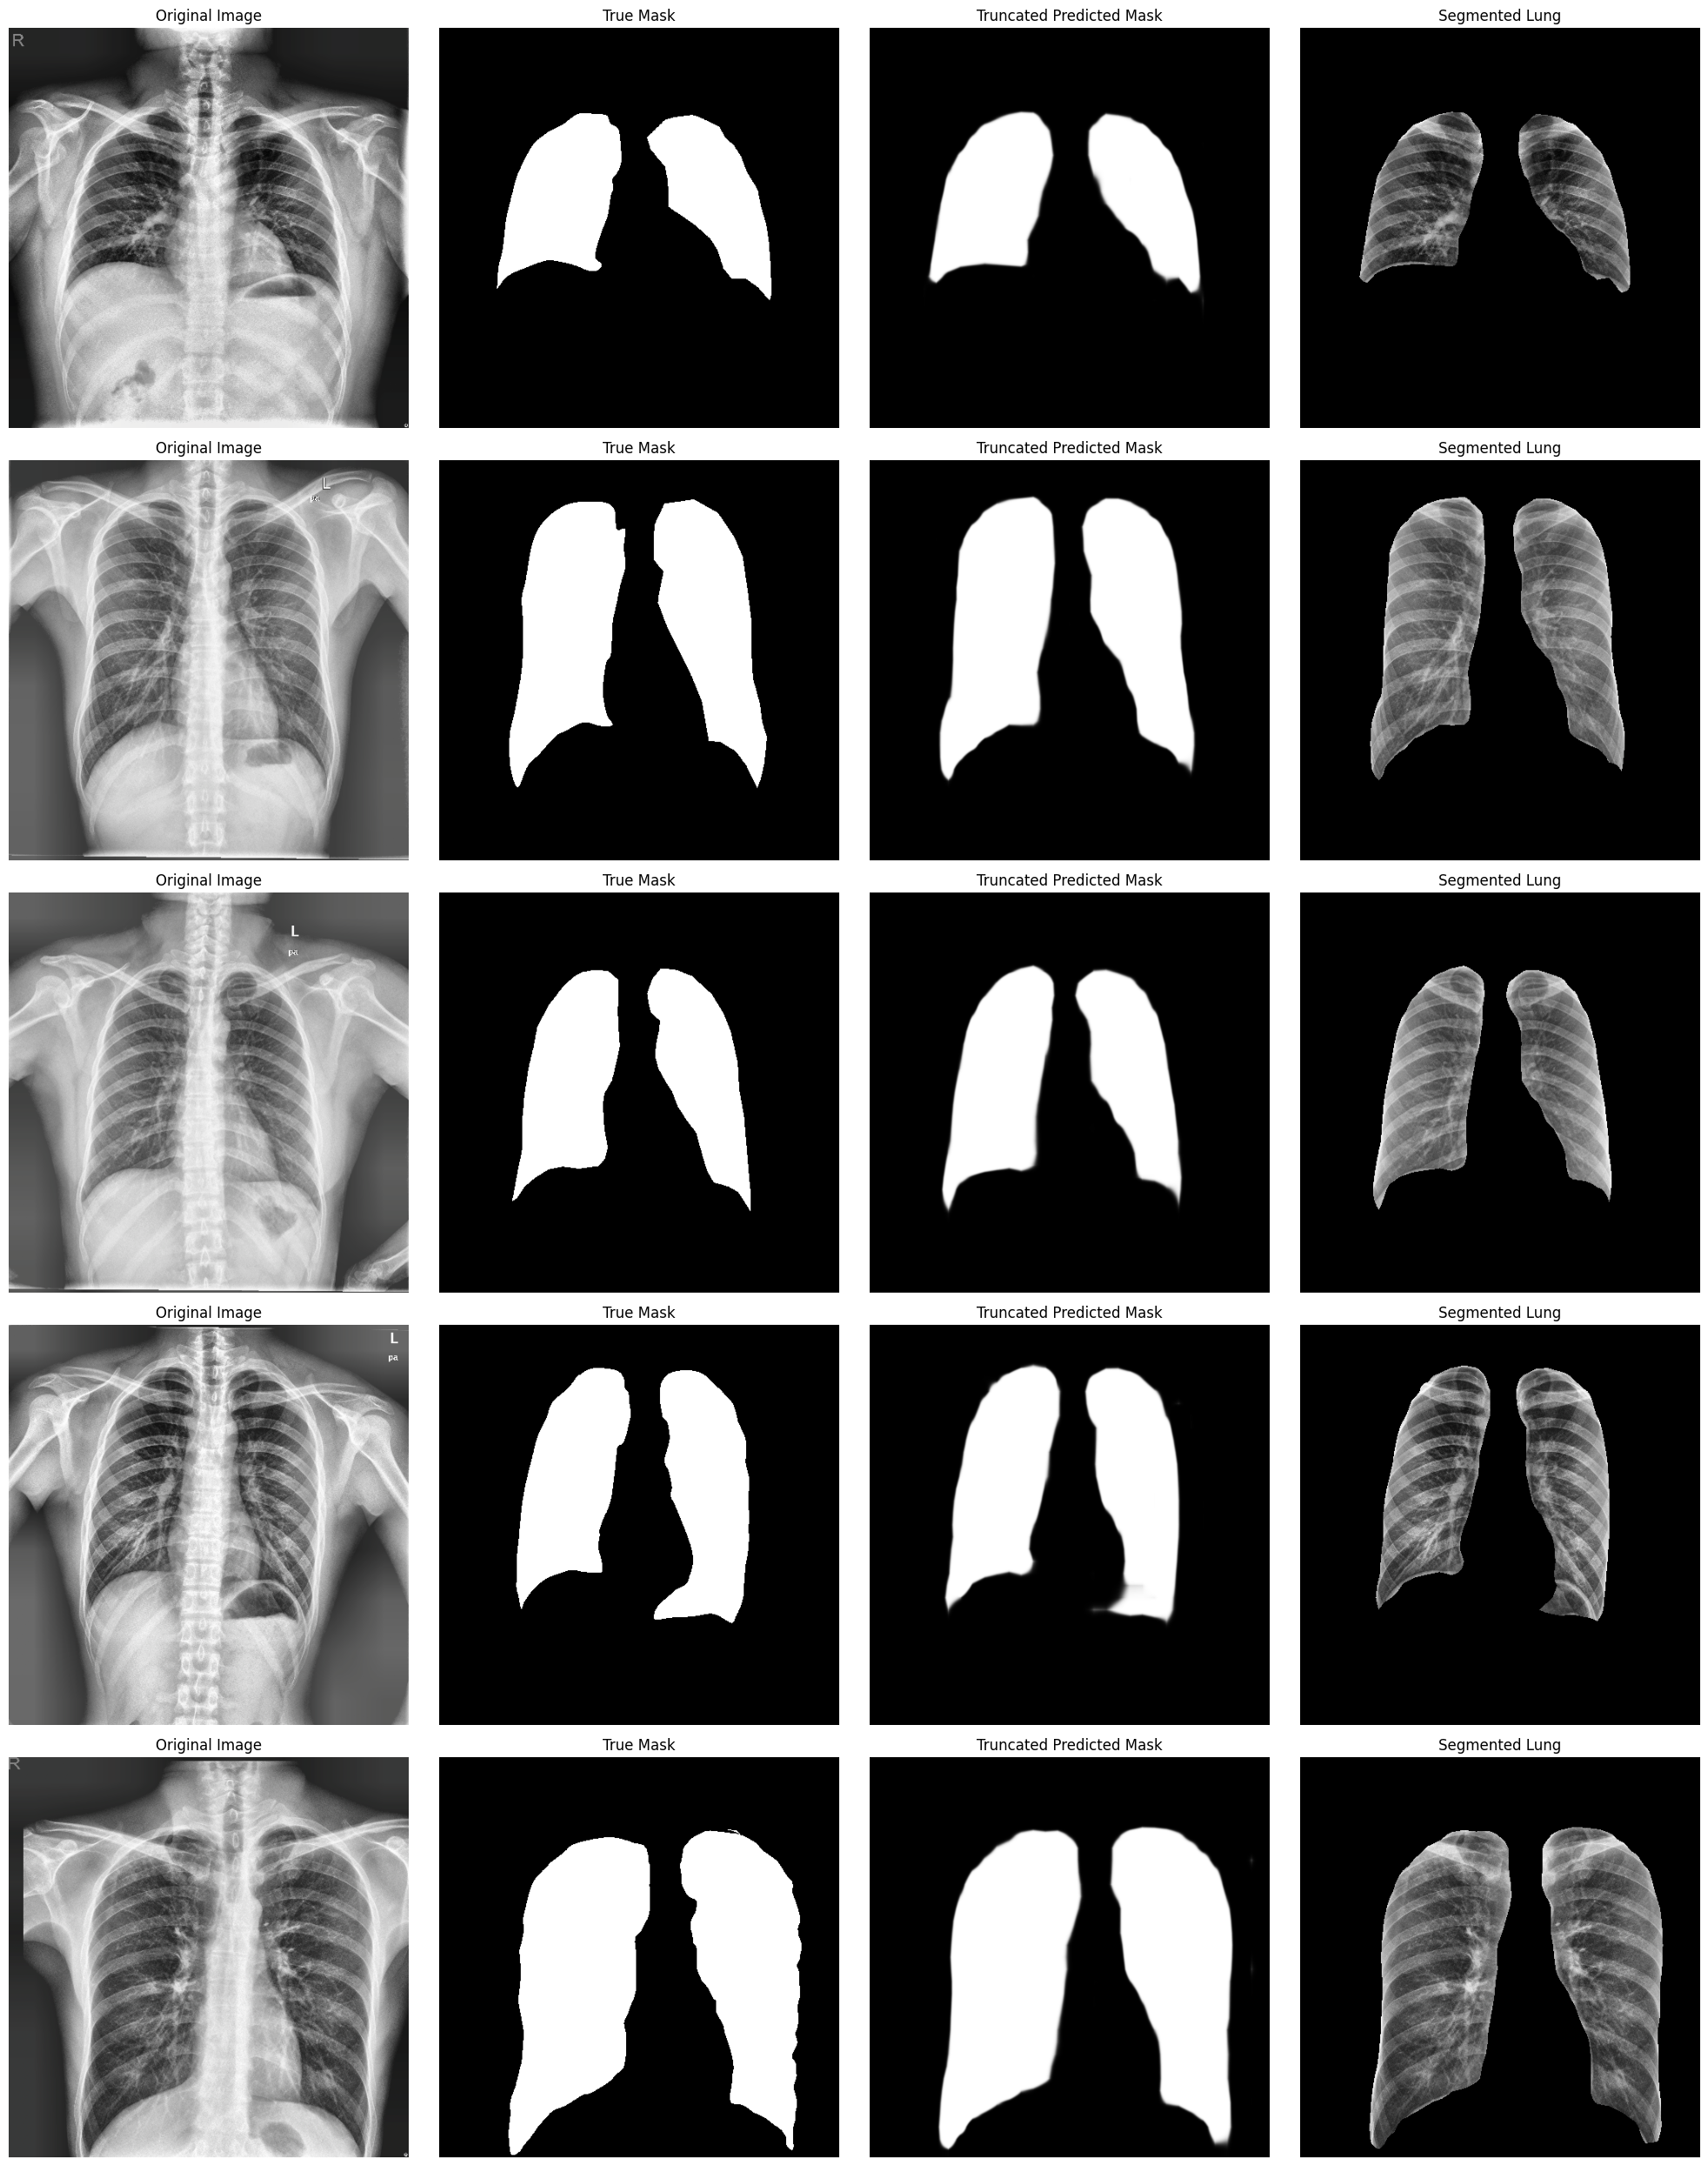

In [35]:
display_random_predictions(model, test_loader.dataset, device)

In [57]:
torch.cuda.empty_cache() 

In [ ]:
def process_batch(batch_filenames, class_name, model, output_dir, min_object_size):
    """
    Process a batch of images: predict masks, post-process them, and save results.

    Parameters:
    - batch_filenames: List of image filenames in the current batch.
    - class_name: The class (tb_positive or tb_negative) of the images.
    - model: The trained lung segmentation model.
    - output_dir: The directory where results will be saved.
    - min_object_size: Minimum size of objects to keep in the mask.

    Returns:
    - List of dictionaries containing paths and labels for the processed images.
    """
    results = []
    
    # Load images into memory
    images = []
    original_paths = []
    
    for filename in batch_filenames:
        image_path = os.path.join(input_dir, class_name, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        images.append(image)
        original_paths.append(image_path)

    # Convert list to numpy array for model input
    images_array = np.array(images)

    # Apply the trained lung segmentation model to predict masks for the entire batch
    predicted_masks = model.predict(images_array[..., None])  # Add channel dimension if needed
    predicted_masks = (predicted_masks > 0.5).astype(np.uint8)

    # Process each mask in the batch
    for j in range(len(batch_filenames)):
        predicted_mask = predicted_masks[j]
        
        # Post-process each predicted mask
        post_processed_mask = post_process_mask(predicted_mask)

        # Generate isolated lung image
        segmented_lung = cv2.bitwise_and(images_array[j], images_array[j], mask=post_processed_mask)

        # Save results
        predicted_mask_path = os.path.join(output_dir, 'predicted_mask', class_name, batch_filenames[j])
        post_processed_mask_path = os.path.join(output_dir, 'post_processed_mask', class_name, batch_filenames[j])
        segmented_lung_path = os.path.join(output_dir, 'segmented_lung', class_name, batch_filenames[j])

        cv2.imwrite(predicted_mask_path, predicted_mask * 255)  # Scale mask for saving as an image
        cv2.imwrite(post_processed_mask_path, post_processed_mask * 255)  # Scale mask for saving as an image
        cv2.imwrite(segmented_lung_path, segmented_lung)

        # Store results in a dictionary
        results.append({
            'input_image_path': original_paths[j],
            'predicted_mask_path': predicted_mask_path,
            'post_processed_mask_path': post_processed_mask_path,
            'segmented_lung_path': segmented_lung_path,
            'label': class_name
        })
    
    return results

def process_images_in_batches(model, input_dir, output_dir, min_object_size=1000, batch_size=32):
    """
    Process all images in batches using ThreadPoolExecutor.

    Parameters:
    - model: The trained lung segmentation model.
    - input_dir: Directory containing input CXR images.
    - output_dir: Directory where processed results will be saved.
    - min_object_size: Minimum size of objects to keep in the mask.
    - batch_size: Number of images to process in each batch.
    
    Returns:
    - DataFrame containing paths and labels for all processed images.
    """
    
    # Create the output directories if they do not exist
    os.makedirs(os.path.join(output_dir, 'segmented_lung', 'tb_positive'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'segmented_lung', 'tb_negative'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'predicted_mask', 'tb_positive'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'predicted_mask', 'tb_negative'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'post_processed_mask', 'tb_positive'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'post_processed_mask', 'tb_negative'), exist_ok=True)

    # Create a DataFrame to store results
    data = {
        'input_image_path': [],
        'predicted_mask_path': [],
        'post_processed_mask_path': [],
        'segmented_lung_path': [],
        'label': []
    }
    
    df = pd.DataFrame(data)

    # Iterate over tb_positive and tb_negative classes
    for class_name in ['tb_positive', 'tb_negative']:
        class_dir = os.path.join(input_dir, class_name)
        
        # Get all image filenames in the class directory
        image_filenames = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png'))]

        with ThreadPoolExecutor() as executor:
            future_to_batch = {executor.submit(process_batch,
                                                image_filenames[i:i + batch_size],
                                                class_name,
                                                model,
                                                output_dir,
                                                min_object_size): i // batch_size 
                                for i in range(0, len(image_filenames), batch_size)}

            for future in tqdm(as_completed(future_to_batch), total=len(future_to_batch), desc=f'Processing {class_name}'):
                try:
                    results = future.result()
                    for result in results:
                        df = df.append(result, ignore_index=True)
                except Exception as exc:
                    print(f'Batch generated an exception: {exc}')

    # Save the CSV dataframe at the end of processing all classes
    df.to_csv('processed_dataset.csv', index=False)

<!-- def free_gpu_memory():
    import torch
    import gc
    
    # Clear PyTorch cache
    torch.cuda.empty_cache()
    
    # Call garbage collection
    gc.collect()
    
    # Print GPU memory status
    print(f"Allocated memory: {torch.cuda.memory_allocated() / (1024 ** 3):.2f} GB")
    print(f"Reserved memory: {torch.cuda.memory_reserved() / (1024 ** 3):.2f} GB")
free_gpu_memory() -->